# Learning the Ising Hamiltonian with Linear Regression

In this notebook we perform linear regression analyses in order to estimate the coupling constant of the one-dimensional Ising model. 

### Configure notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from sklearn.utils import resample

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Import code from src
sys.path.insert(0, '../src/')
from isingmodel import bias_variance, generate_1Ddata
from linearmodel import OLS, Lasso, Ridge
from project_tools import fig_path

### Set up Regression models

In [4]:
ols = OLS(fit_intercept=False)
ridge = Ridge(fit_intercept=False)
lasso = Lasso(fit_intercept=False)

### Generate data for the one-dimesional Ising model

In [5]:
# generate data
np.random.seed(42)
L = 40     # system size
N = 10000  # number of points
data, target = generate_1Ddata(L, N)
#target = target + np.random.normal(0, 4.0, size=N)

X_train, X_test, y_train, y_test = ols.split_data(data, target, 0.96)

## Linear Regression with OLS

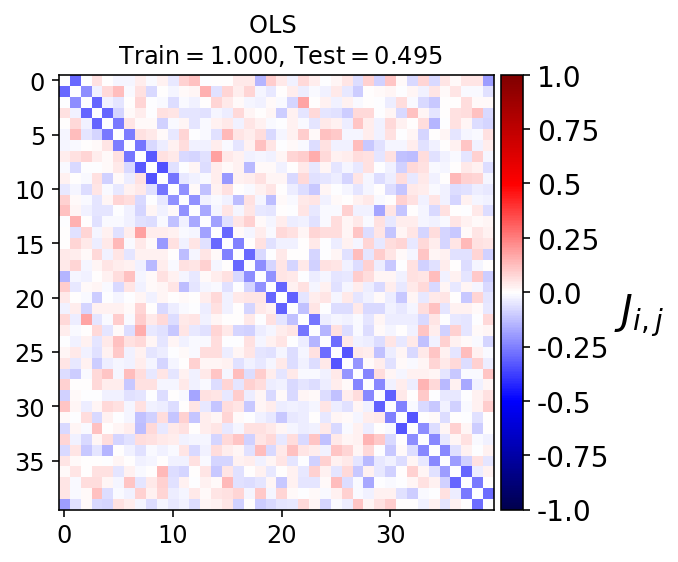

In [6]:
ols.fit(X_train, y_train)  # fit model

J_ols = np.array(ols.coef_).reshape((L, L))

cmap_args = dict(vmin=-1., vmax=1., cmap='seismic')
fig, ax0 = plt.subplots()

im = ax0.imshow(J_ols, **cmap_args)
ax0.set_title('OLS \n Train$={:.3f}$, Test$={:.3f}$'.format(
    ols.r2(X_train, y_train), ols.r2(X_test, y_test)))

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_yticklabels(np.arange(-1.0, 1.0 + 0.25, 0.25), fontsize=14)
cbar.set_label('$J_{i,j}$', labelpad=15, y=0.5, fontsize=20, rotation=0)

fig.savefig(fig_path("ising_J_ols.pdf"), bbox_inches='tight')
plt.show()

## Linear Regression with Ridge and Lasso

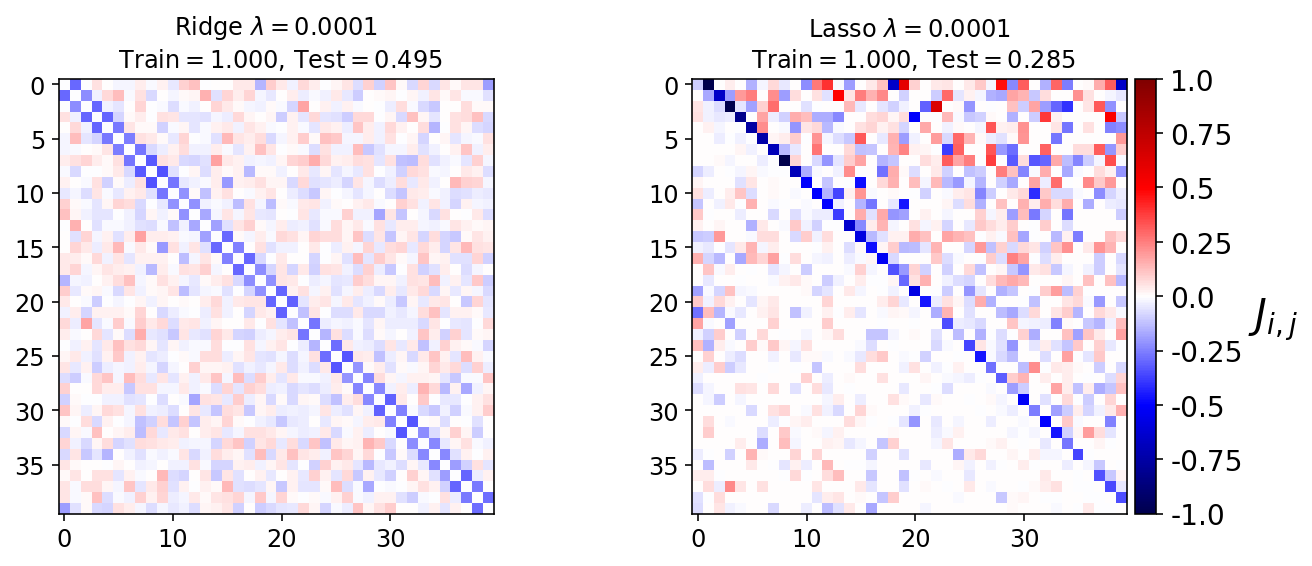

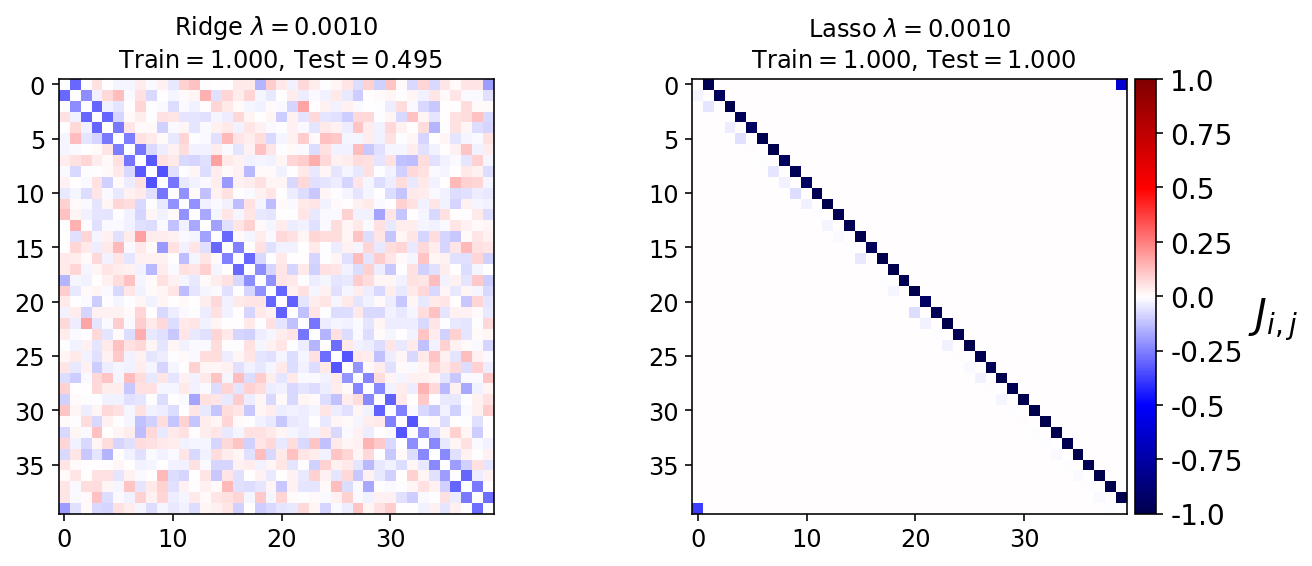

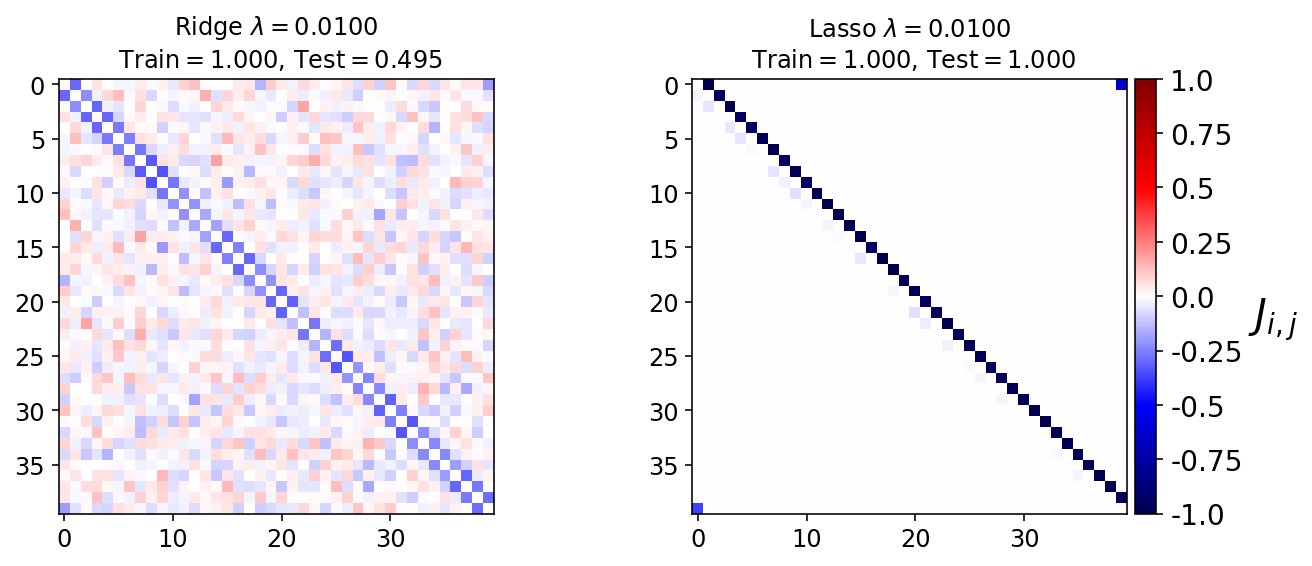

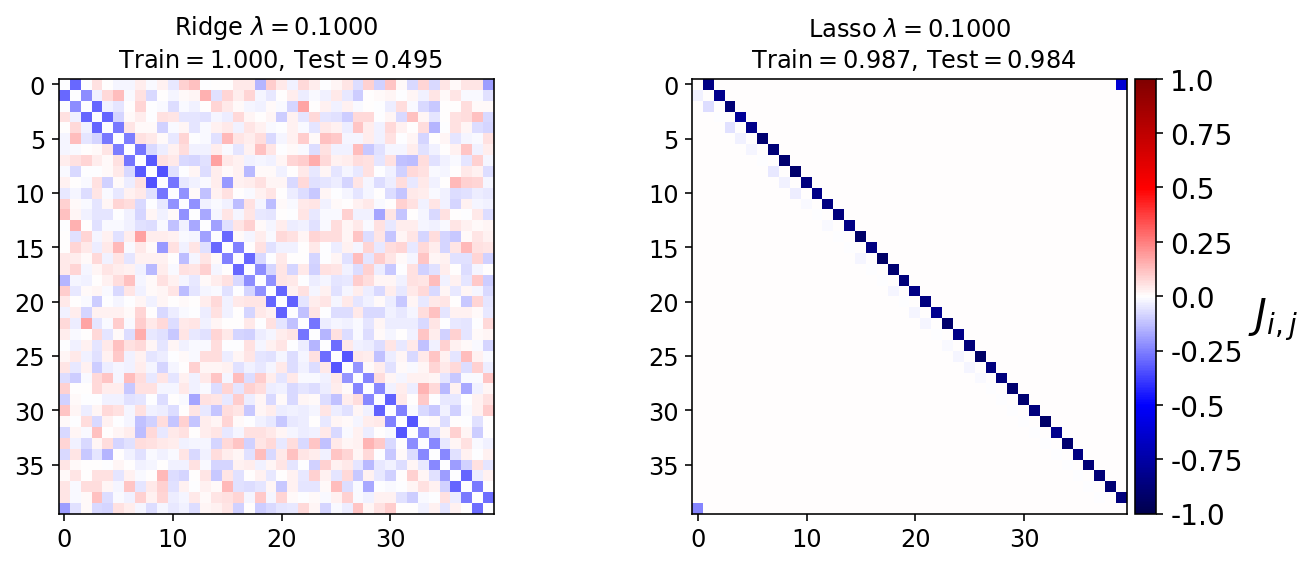

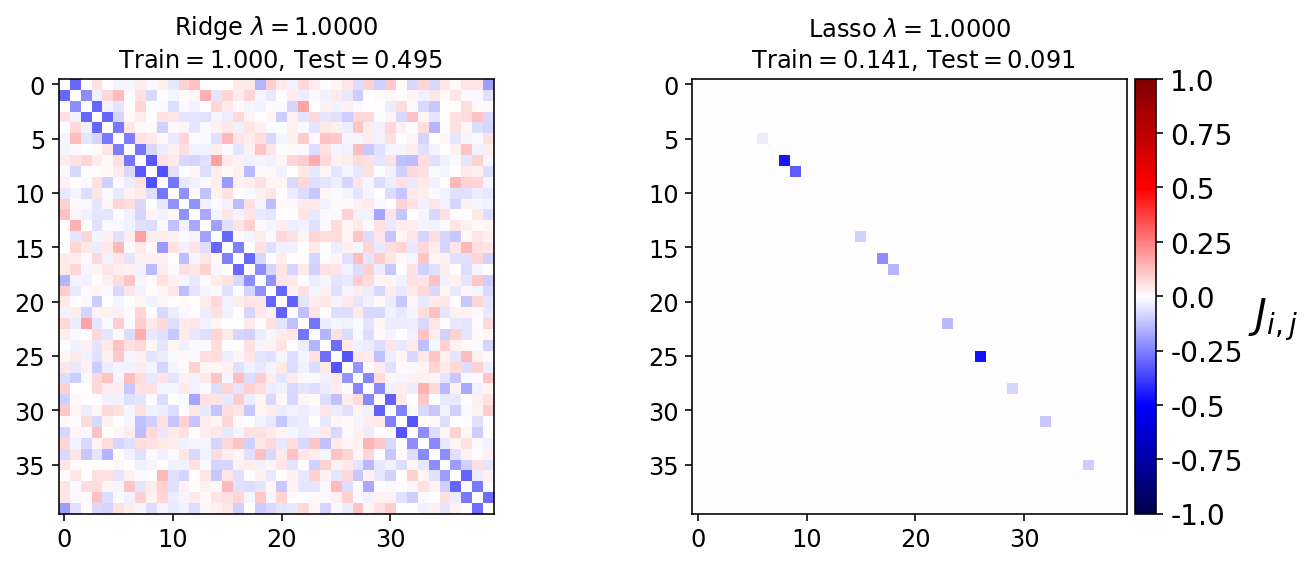

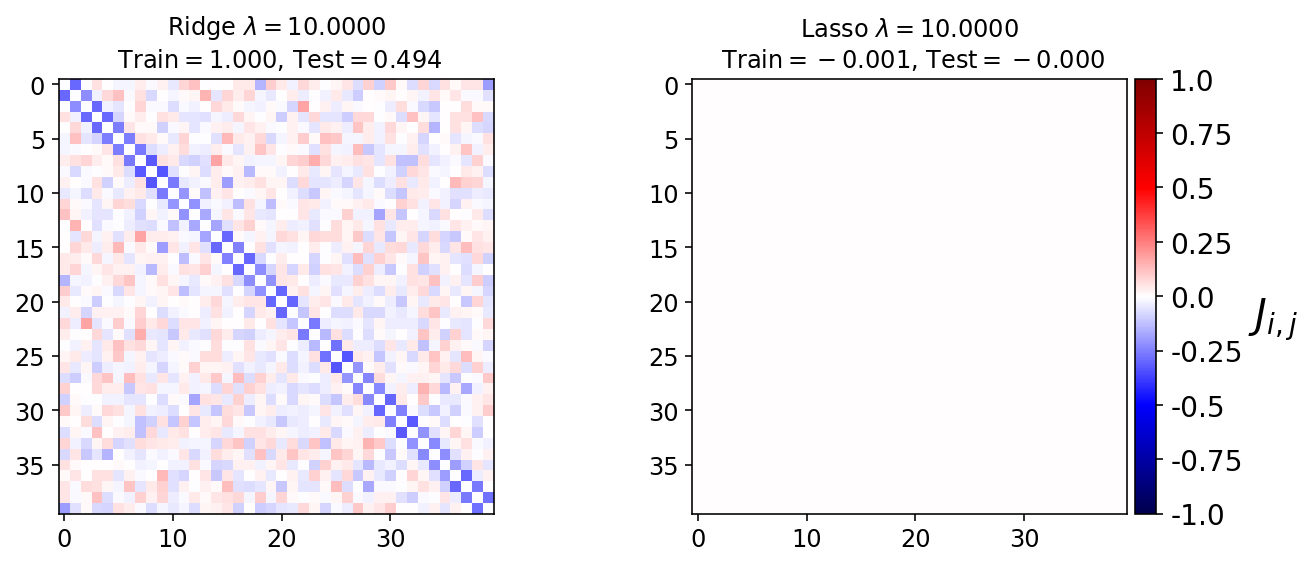

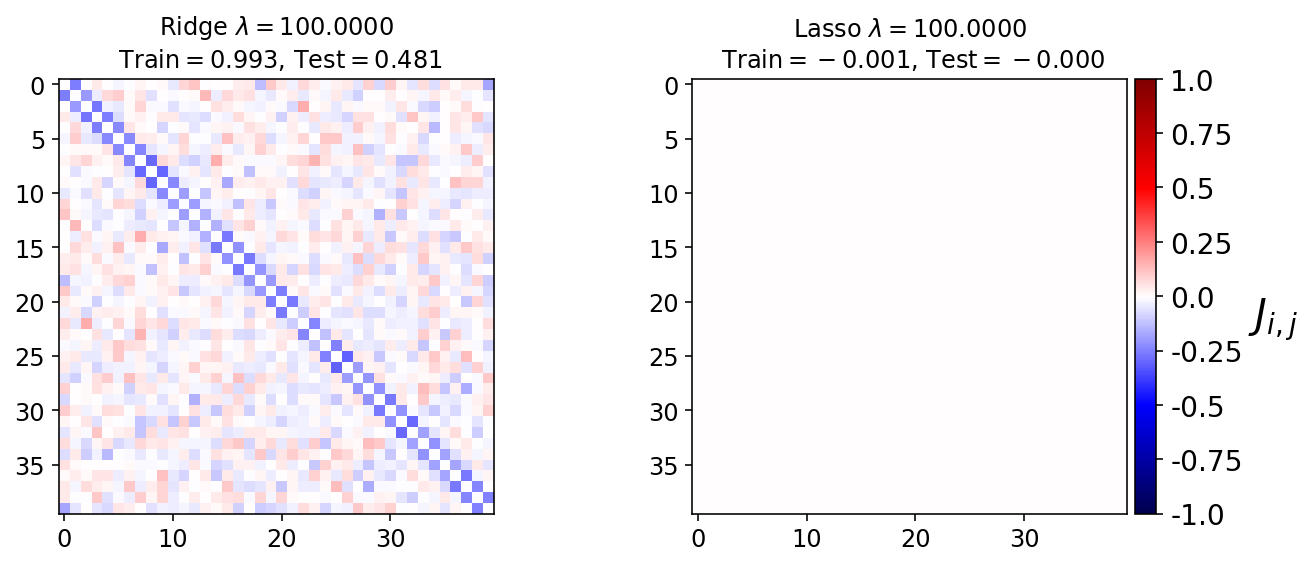

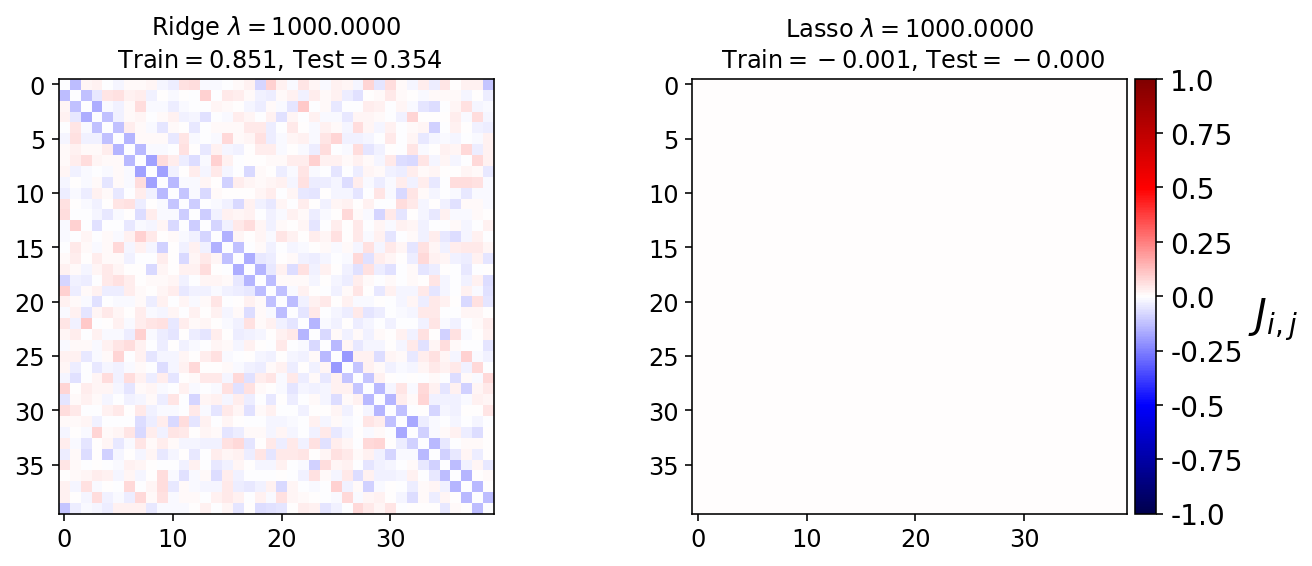

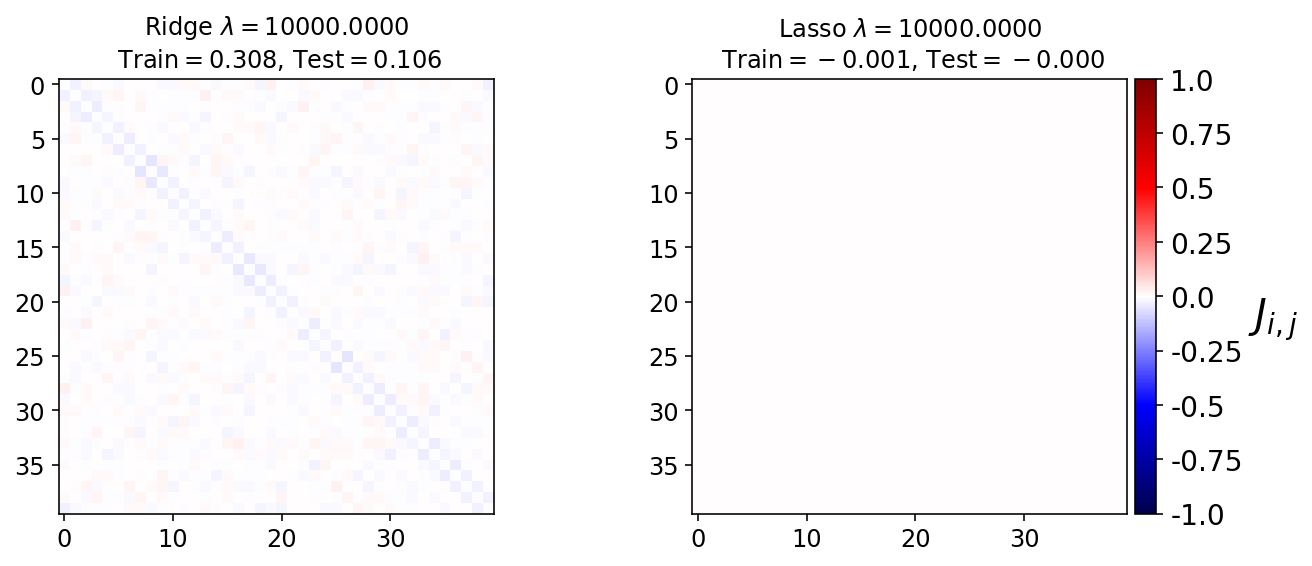

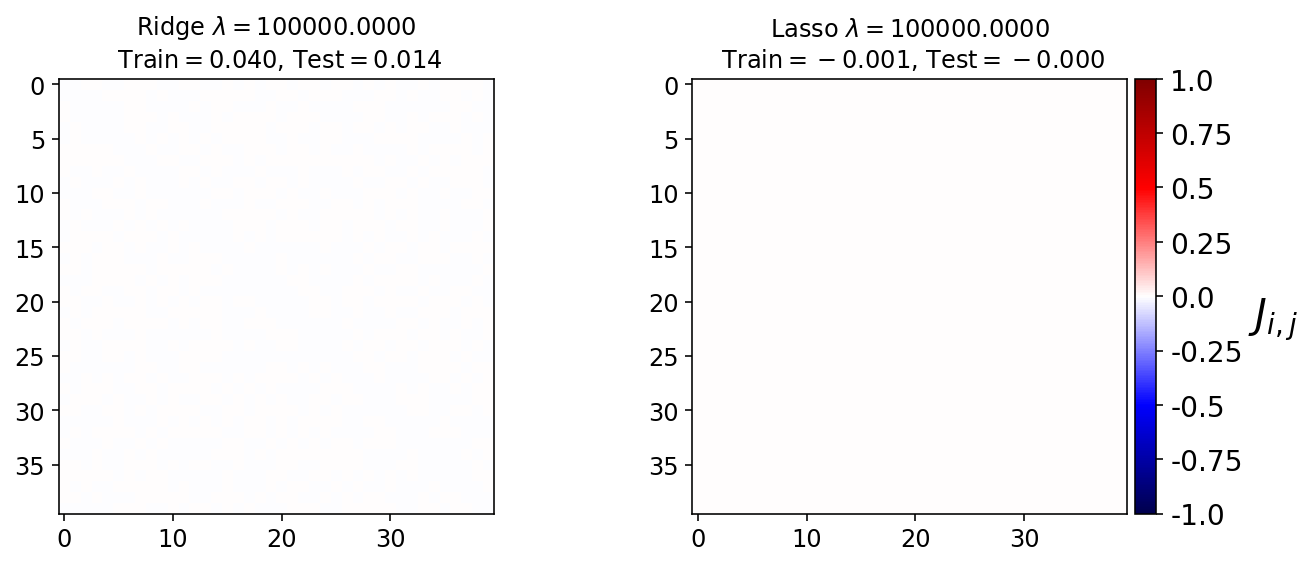

In [7]:
n = 10
# set regularisation strength values
lmbdas = np.logspace(-4, 5, n)

# use the coefficient of determination R^2 as the performance of prediction.
r2_train_ols = np.full(n, ols.r2(X_train, y_train))
r2_test_ols = np.full(n, ols.r2(X_test, y_test))
mse_train_ols = np.full(n, ols.mse(X_train, y_train))
mse_test_ols = np.full(n, ols.mse(X_test, y_test))


r2_train_ridge = np.zeros(n)
r2_test_ridge = np.zeros(n)
mse_train_ridge = np.zeros(n)
mse_test_ridge = np.zeros(n)

r2_train_lasso = np.zeros(n)
r2_test_lasso = np.zeros(n)
mse_train_lasso = np.zeros(n)
mse_test_lasso = np.zeros(n)

coef_ols = np.tile(ols.coef_, (n, 1))  # store weights
coefs_ridge = []
coefs_lasso = []

for i, lmbda in enumerate(lmbdas):
    # apply RIDGE regression
    ridge.set_penalty(lmbda)             # set regularisation parameter
    ridge.fit(X_train, y_train)          # fit model
    coefs_ridge.append(ridge.coef_)      # store weights
    # use the coefficient of determination R^2 as the performance of prediction
    r2_train_ridge[i] = ridge.r2(X_train, y_train)
    r2_test_ridge[i] = ridge.r2(X_test, y_test)
    mse_train_ridge[i] = ridge.mse(X_train, y_train)
    mse_test_ridge[i] = ridge.mse(X_test, y_test)

    # apply LASSO regression
    lasso.set_penalty(lmbda)             # set regularisation parameter
    lasso.fit(X_train, y_train)          # fit model
    coefs_lasso.append(lasso.coef_)      # store weights
    # use the coefficient of determination R^2 as the performance of prediction
    r2_train_lasso[i] = lasso.r2(X_train, y_train)
    r2_test_lasso[i] = lasso.r2(X_test, y_test)
    mse_train_lasso[i] = lasso.mse(X_train, y_train)
    mse_test_lasso[i] = lasso.mse(X_test, y_test)

    J_ridge = np.array(ridge.coef_).reshape((L, L))
    J_lasso = np.array(lasso.coef_).reshape((L, L))

    cmap_args = dict(vmin=-1., vmax=1., cmap='seismic')
    fig, axarr = plt.subplots(nrows=1, ncols=2)

    axarr[0].imshow(J_ridge, **cmap_args)
    axarr[0].set_title('Ridge $\lambda={:.4f}$\n Train$={:.3f}$, Test$={:.3f}$'.format(
        lmbda, r2_train_ridge[i], r2_test_ridge[i]))

    im = axarr[1].imshow(J_lasso, **cmap_args)
    axarr[1].set_title('Lasso $\lambda={:.4f}$\n Train$={:.3f}$, Test$={:.3f}$'.format(
        lmbda, r2_train_lasso[i], r2_test_lasso[i]))

    divider = make_axes_locatable(axarr[1])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0 + 0.25, 0.25), fontsize=14)
    cbar.set_label('$J_{i,j}$', labelpad=15, y=0.5, fontsize=20, rotation=0)
    fig.subplots_adjust(right=1.5)
    
    
    text_lmbda = str(round(lmbda, 4)).replace(".", "_")
    fig.savefig(fig_path("ising_J_lmbda_{}.pdf".format(text_lmbda)), bbox_inches='tight')
    plt.show()

# Assess Models

### R2 score as a measure of performance

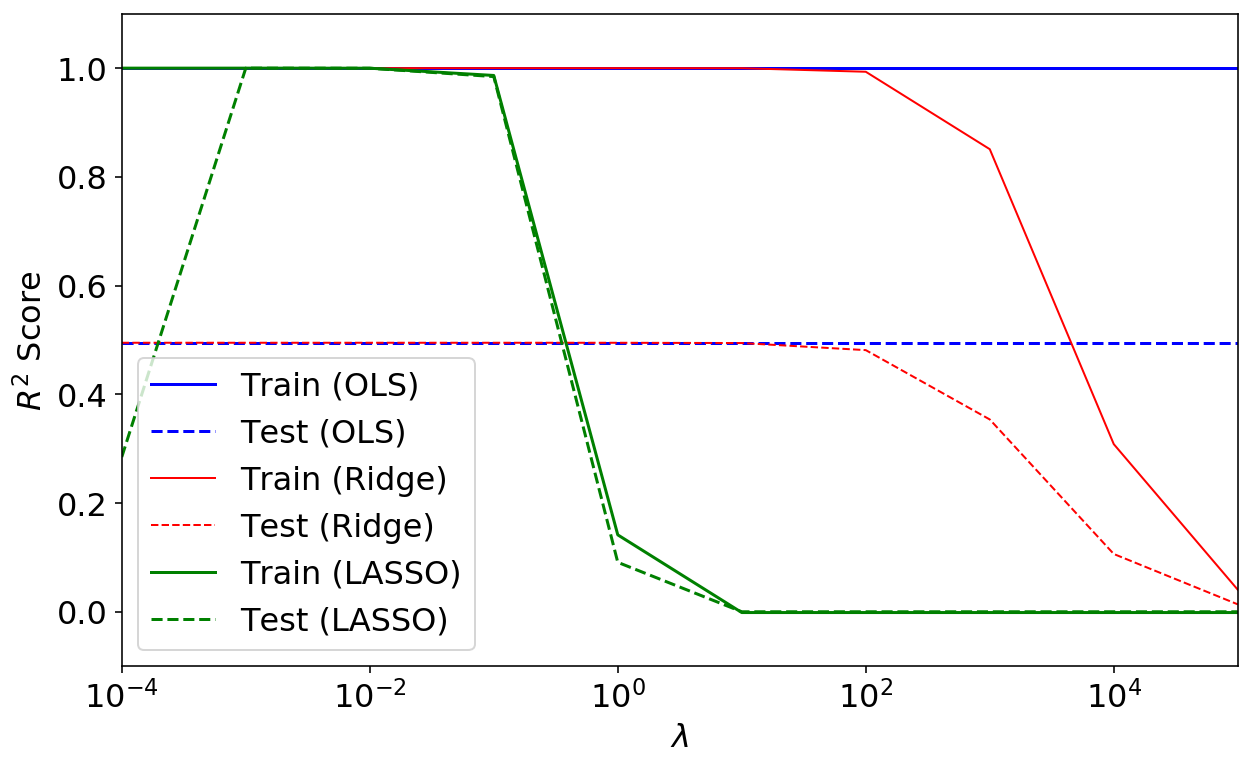

In [8]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, r2_train_ols, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, r2_test_ols,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, r2_train_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, r2_test_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, r2_train_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, r2_test_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('$R^2$ Score',fontsize=16)
plt.tick_params(labelsize=16)
fig.savefig(fig_path("ising1D_r2_vs_lmbda.pdf"))
plt.show()

### MSE as a measure of performance

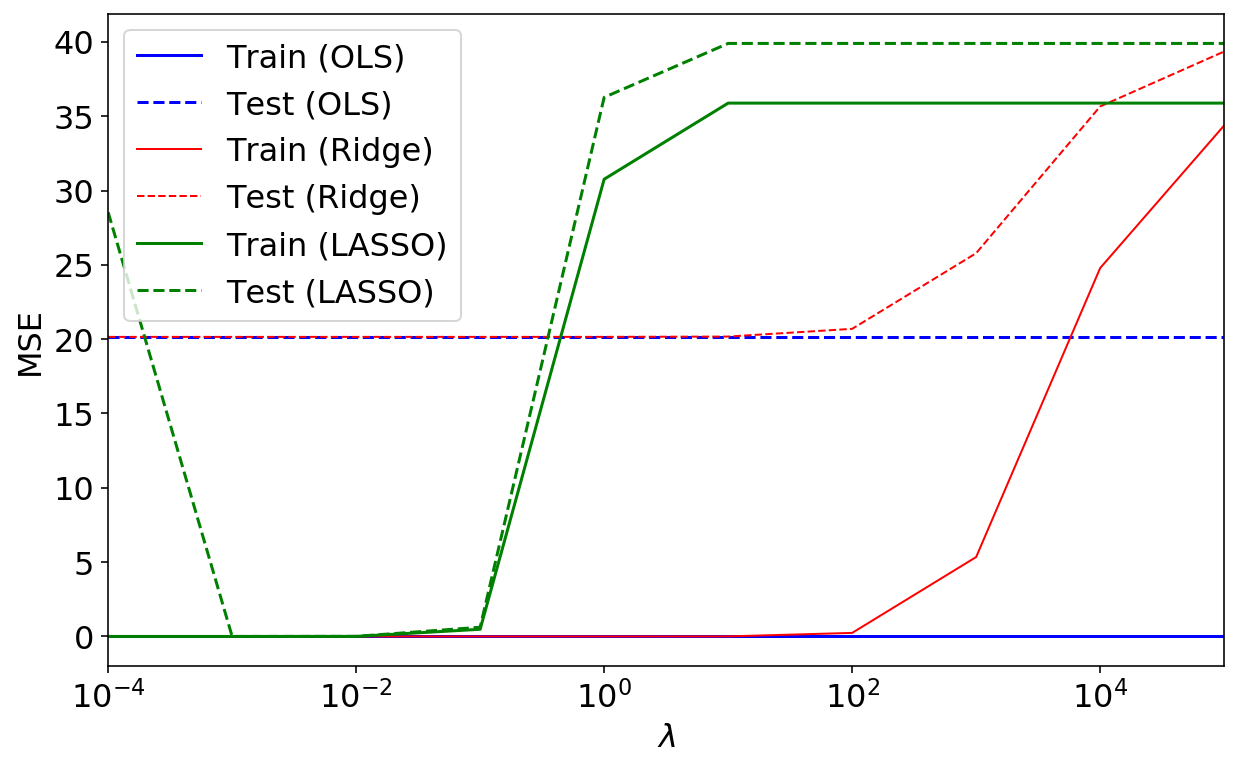

In [9]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, mse_train_ols, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, mse_test_ols,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, mse_train_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, mse_test_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, mse_train_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, mse_test_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

plt.legend(loc='upper left',fontsize=16)
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=16)
fig.savefig(fig_path("ising1D_mse_vs_lmbda.pdf"))
plt.show()

## Bias-variance analysis using bootstrap

In [ ]:
L = 20                                 # system size
N = 1200                               # number of points
n_bootstraps = 15                      # number of bootstraps
n_lmbdas = 20                          # number of regularization parameters
lmbdas = np.logspace(-4, 5, n_lmbdas)  # regularization parameters

# Initialize models
ols = OLS(fit_intercept=False)
ridge = Ridge(fit_intercept=False)
lasso = Lasso(fit_intercept=False)

# Generate and split data
data, target = generate_1Ddata(L, N)
# target = target + np.random.normal(0, 4.0, size=N)
X_train, X_test, y_train, y_test = ols.split_data(data, target, 0.33)
y_test = y_test.reshape(-1, 1)

# Ridge & Lasso
y_pred_ridge = np.empty((y_test.shape[0], n_bootstraps))
y_pred_lasso = np.empty((y_test.shape[0], n_bootstraps))

error_ridge = np.empty((lmbdas.shape[0]))
bias_ridge = np.empty((lmbdas.shape[0]))
variance_ridge = np.empty((lmbdas.shape[0]))

error_lasso = np.empty((lmbdas.shape[0]))
bias_lasso = np.empty((lmbdas.shape[0]))
variance_lasso = np.empty((lmbdas.shape[0]))
                          
for i, lmbda in enumerate(lmbdas):
    for j in range(n_bootstraps):
        X_, y_ = resample(X_train, y_train)
        
        ridge.set_penalty(lmbda)
        ridge.fit(X_, y_)
        y_pred_ridge[:, j] = ridge.predict(X_test).ravel()
        
        lasso.set_penalty(lmbda)
        lasso.fit(X_, y_)
        y_pred_lasso[:, j] = lasso.predict(X_test).ravel() 
            
    error_ridge[i] = np.mean(np.mean((y_test - y_pred_ridge)**2, axis=1, keepdims=True))
    bias_ridge[i] = np.mean((y_test - np.mean(y_pred_ridge, axis=1, keepdims=True))**2)
    variance_ridge[i] = np.mean(np.var(y_pred_ridge, axis=1, keepdims=True))
    
    error_lasso[i] = np.mean(np.mean((y_test - y_pred_lasso)**2, axis=1, keepdims=True)) 
    bias_lasso[i] = np.mean((y_test - np.mean(y_pred_lasso, axis=1, keepdims=True))**2)
    variance_lasso[i] = np.mean(np.var(y_pred_lasso, axis=1, keepdims=True))

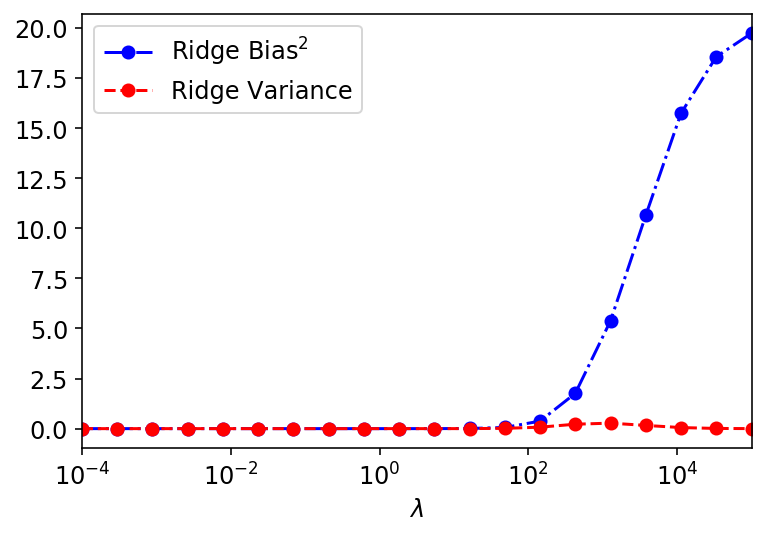

In [15]:
plt.semilogx(lmbdas, bias_ridge, 'b-.o', label='Ridge Bias$^2$')
plt.semilogx(lmbdas, variance_ridge, 'r--o', label='Ridge Variance')
#plt.semilogx(lmbdas, error_ridge, 'g', label='Ridge Error')

plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel('$\lambda$')
plt.legend(loc='best')
fig.savefig(fig_path("ising1D_ridge_bias_variance.pdf"))
plt.show()

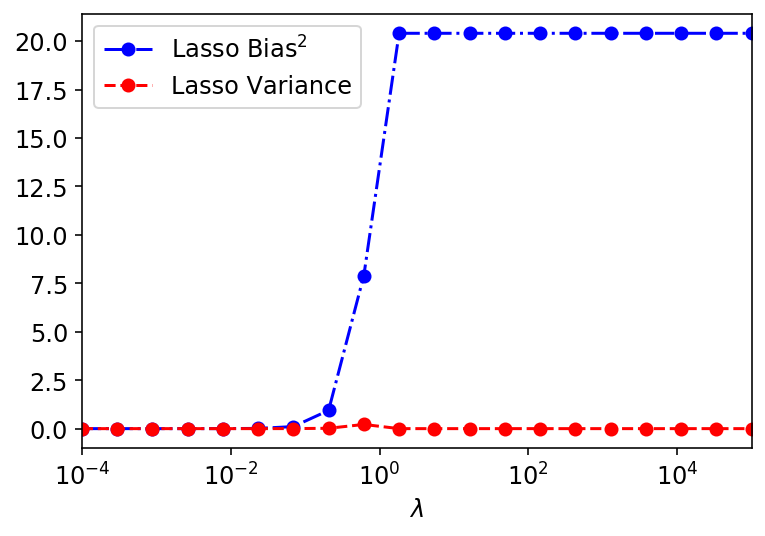

In [16]:
plt.semilogx(lmbdas, bias_lasso, 'b-.o', label='Lasso Bias$^2$')
plt.semilogx(lmbdas, variance_lasso, 'r--o', label='Lasso Variance')
#plt.semilogx(lmbdas, error_lasso, 'g', label='Ridge Error')

plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel('$\lambda$')
plt.legend(loc='best')
fig.savefig(fig_path("ising1D_lasso_bias_variance.pdf"))
plt.show()